# 0. Используемые библиотеки

In [33]:
import numpy as np  # библиотека для работы с числовыми данными
import pandas as pd  # библиотека для обработки и анализа данных
 
import matplotlib.pyplot as plt  # библиотека для визуализации изображений датасета

import torch  # библиотека для работы с нейронными сетями 
from torch import nn  # для реализации и обучения нейронной сети
from torch.utils.data import Dataset, DataLoader  # для создания кастомного датасета и загрузки данных
import torchmetrics  # библиотека для использования метрик эффективности
import tensorboard  # библиотека для визуализации процесса обучения
from torchvision import transforms  # для преобразования изображений в тензор

import os  # библиотека для работы с интерфейсами операционной системы

from skimage import io  # для работы с изображениями
from PIL import Image  # для работы с изображениями

import lightning.pytorch as pl  # библиотека для автоматизации процесса оптимизации обучения
from lightning.pytorch import Trainer  # для обучения модели

import timm  # библиотека с моделями 

from sklearn.metrics import accuracy_score, f1_score  # для проверки качества модели с помощью sklearn

# 1. Подготовка датасета

Для решения задачи классификации был получен датасет, содержащий изображения автомобилей Hyundai Solaris и соответсвующие разметки повреждений.
#### Пример изображений: 

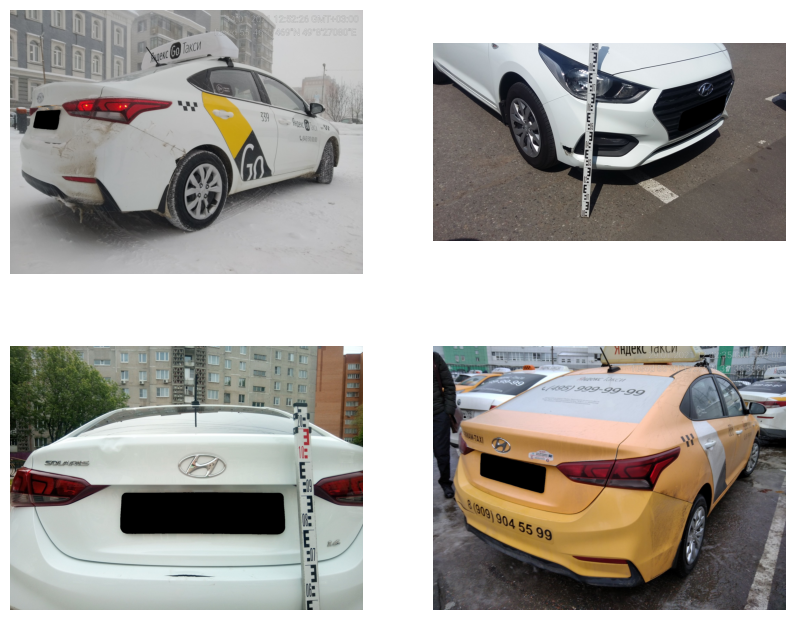

In [2]:
folder_dir = "C:\\Users\\nicol\\NN\\КУРСАЧ\\solaris_damage_0_4_3\\images"
images_list =  os.listdir(folder_dir)  # список названий изображений
indexes = np.random.randint(0, len(images_list), size=4)  # случайные индексы для визуализации 

fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2) 
axes = ax.ravel()
for i in range(len(indexes)):
    image = Image.open(folder_dir + '\\' + images_list[indexes[i]], mode='r')
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

Изначально датасет был разделён на трейновый и валидационный. Этот этап предполагался после предобработки и анализа данных, поэтому было принято решение объединить их в один:

In [3]:
df_train = pd.read_json('solaris_damage_0_4_3/train_damage.json').T  # считывание даных в датафрейм
df_val = pd.read_json('solaris_damage_0_4_3/val_damage.json').T  # считывание даных в датафрейм

data = pd.concat([df_train, df_val])
data.head() 

,fileref,size,filename,base64_img_data,file_attributes,regions
837010425_ph-1612345459140.jpg463108,,463108,837010425_ph-1612345459140.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
755222515_ph-1592810208762.jpg243985,,243985,755222515_ph-1592810208762.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
776217682_ph-1598080258160.jpg414012,,414012,776217682_ph-1598080258160.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
791808053_ph-1601632702874.jpg576829,,576829,791808053_ph-1601632702874.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
760090860_ph-1594117414434.jpg506029,,506029,760090860_ph-1594117414434.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."


In [4]:
print(f'Количество строк датафрейма: {data.shape[0]}\n\
Количество столбцов датафрейма: {data.shape[1]}')

Количество строк датафрейма: 4273
Количество столбцов датафрейма: 6


Столбец **regions** представляет собой набор словарей, содержащих информацию о повреждениях автомобилей в виде кривой, задающейся с помощью списка координат, находящихся под ключами **all_points_x** и **all_points_y**.

В процессе анализа данных было выявлено, что записи для неповреждённых автомобилей в столбце **regions** содержат пустой словарь, поэтому было принято решение создать колонку **damage**, в которой будет храниться:

0 - если автомобиль не повреждён\
1 - если автомобиль повреждён

In [5]:
damage = np.where(data['regions'] != {}, 1, 0)  # функция, возвращающая массив из 0 и 1 в зависимости от условия
data['damage'] = damage  # дабавление столбца
data.head() 

,fileref,size,filename,base64_img_data,file_attributes,regions,damage
837010425_ph-1612345459140.jpg463108,,463108,837010425_ph-1612345459140.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
755222515_ph-1592810208762.jpg243985,,243985,755222515_ph-1592810208762.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
776217682_ph-1598080258160.jpg414012,,414012,776217682_ph-1598080258160.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
791808053_ph-1601632702874.jpg576829,,576829,791808053_ph-1601632702874.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
760090860_ph-1594117414434.jpg506029,,506029,760090860_ph-1594117414434.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1


Теперь мы получили датасет, в явном виде содержащий целевую переменную.
##### Визуализируем данные:

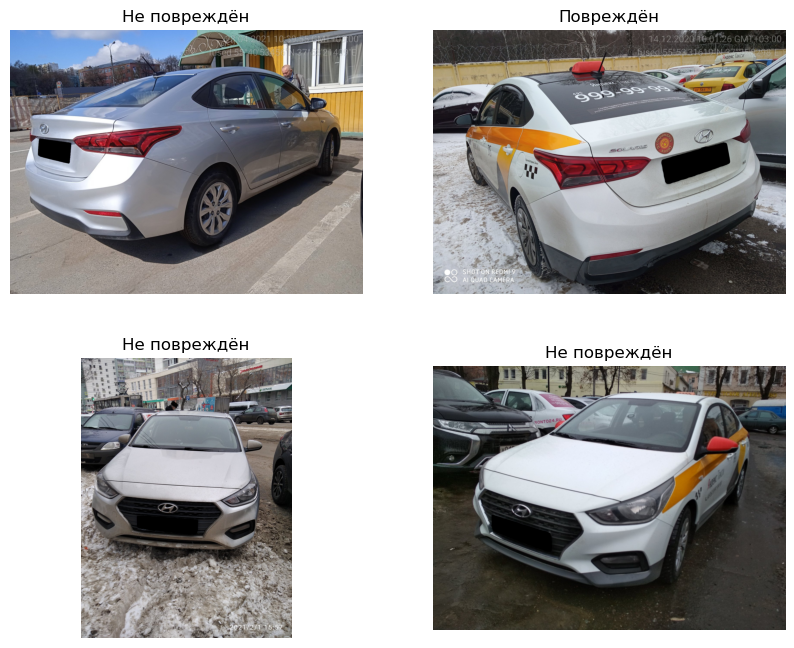

In [6]:
indexes = np.random.randint(0, len(images_list), size=4)  # случайные индексы для визуализации

fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2) 
axes = ax.ravel()
for i in range(len(indexes)):
    image = Image.open(folder_dir + '\\' + data['filename'][indexes[i]], mode='r')
    axes[i].imshow(image, cmap='gray')
    if data['damage'][indexes[i]] == 1:
        title = 'Повреждён'
    else:
        title = 'Не повреждён'
    axes[i].set_title(title)
    axes[i].axis('off')

In [7]:
print(f'Количество строк датафрейма: {data.shape[0]}\n\
Количество изображений: {len(images_list)}')

Количество строк датафрейма: 4273
Количество изображений: 4102


Кроме того, оказалось, что количество записей датафрейма несколько больше количества изображений, поэтому было принято решение оставить только те строки, для которых есть фотографии.

Отбор записей был осуществлён с помощью проверки каждого значения столбца **filename** на вхождение в список названий изображений, полученный ранее:

In [8]:
data = data[data['filename'].isin(images_list)]

In [9]:
print(f'Количество строк датафрейма: {data.shape[0]}\n\
Количество изображений: {len(images_list)}')

Количество строк датафрейма: 4087
Количество изображений: 4102


Мы видим, что количество изображений превышает количество записей, но это не так критично. Теперь мы уверены, что для каждой строки датафрейма найдётся фотография.

Выведем размер каждого класса:

In [10]:
print(f'Количество повреждённых автомобилей: {data["damage"].value_counts()[1]}\n\
Количество неповреждённых автомобилей: {data["damage"].value_counts()[0]}')

Количество повреждённых автомобилей: 2534
Количество неповреждённых автомобилей: 1553


Отношение неповреждённых автомобилей к повреждённым примерно **2:3**, поэтому можно сказать, что явное доминирование одного класса над другим отсутствует.

# 2. Создание кастомного датасета

Стоит отметить, что модели для обучения используют объекты класса **DataLoader**, одним из атрибутов которого является датасет. Кроме того, модель работает с изображением, представленным в виде тензора.

Нам необходимо создать кастомный датасет, который будет содержать в себе изображение в виде тензора, а также значение класса.
##### Выбор данных:

In [11]:
images = data['filename'].values  # имена изображений, передаваемые в атрибут класса
damages = data['damage'].values  # повреждения, передаваемые в атрибут класса в виде 0 и 1

Был создан класс **DamageDataset**, родительским классом которого является класс **Dataset** из torch.utils.data: 

In [12]:
class DamageDataset(Dataset):

    def __init__(self, images, damages, root_dir, transform=None):  
        self.images = images  # инициализируем изображения
        self.damages = damages  #  инициализируем повреждения
        self.root_dir = root_dir  #  инициализируем корневую папку
        self.transform = transform  # инициализируем преобразования
        
    def __len__(self):  #  возвращаеm количество выборок в наборе данных
        return len(self.damages)  
    
    def __getitem__(self, idx):  # загружаем и возвращаем выборку из набора данных с заданным индексом
        if torch.is_tensor(idx):  
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.images[idx])  # получаем путь изображения
        image = self.transform(io.imread(img_name))  # преобразовываем изображение в тензор
        image = torch.nn.functional.adaptive_avg_pool2d(image, (400, 600))  # приводим изображения к одному размеру
        damage = torch.tensor(self.damages[idx]).to(torch.int64)  # преобразовываем целевую переменную
        
        sample = (image, damage)

        return sample

##### Создание объекта класса:

In [13]:
damage_dataset = DamageDataset(images = images, 
                               damages = damages, 
                               root_dir = folder_dir,
                               transform = transforms.ToTensor()
)

В итоге мы получаем набор кортежей, содержащих изображение и класс в виде тензоров.
##### Пример:

In [14]:
damage_dataset[0][0]  # изображение в виде тензора

tensor([[[0.9958, 0.9975, 0.9939,  ..., 0.3566, 0.4610, 0.2533],
         [0.9680, 0.9664, 0.9659,  ..., 0.4424, 0.4027, 0.2474],
         [0.9745, 0.9701, 0.9681,  ..., 0.3980, 0.3025, 0.3049],
         ...,
         [0.3422, 0.3395, 0.3603,  ..., 0.8248, 0.7946, 0.7735],
         [0.3023, 0.3446, 0.3679,  ..., 0.8422, 0.8336, 0.8150],
         [0.3046, 0.3301, 0.3495,  ..., 0.8145, 0.8257, 0.8359]],

        [[0.9961, 0.9978, 0.9949,  ..., 0.3539, 0.4578, 0.2477],
         [0.9631, 0.9620, 0.9627,  ..., 0.4373, 0.3961, 0.2392],
         [0.9755, 0.9708, 0.9691,  ..., 0.3890, 0.2922, 0.3173],
         ...,
         [0.3448, 0.3360, 0.3453,  ..., 0.8199, 0.7897, 0.7637],
         [0.3075, 0.3426, 0.3547,  ..., 0.8324, 0.8238, 0.8020],
         [0.3118, 0.3301, 0.3382,  ..., 0.8015, 0.8096, 0.8170]],

        [[0.9899, 0.9919, 0.9870,  ..., 0.3699, 0.4610, 0.2559],
         [0.9775, 0.9740, 0.9718,  ..., 0.4588, 0.4184, 0.2716],
         [0.9810, 0.9765, 0.9703,  ..., 0.4142, 0.3282, 0.

In [15]:
damage_dataset[0][1]  # класс в виде тензора

tensor(1)

# 3. Разбиение датасета

In [16]:
seed = torch.Generator().manual_seed(42)

train_to_valid_size = int(len(damage_dataset) * 0.8)
test_size = len(damage_dataset) - train_to_valid_size

train_to_valid_set, test_set = torch.utils.data.random_split(damage_dataset, [train_to_valid_size, test_size], generator=seed)

In [17]:
train_size = int(len(train_to_valid_set) * 0.8)
valid_size = len(train_to_valid_set) - train_size

train_set, valid_set = torch.utils.data.random_split(train_to_valid_set, [train_size, valid_size], generator=seed)

In [18]:
num_classes = data['damage'].nunique()  # количесвто классов

In [19]:
model1 = timm.create_model('resnet26', pretrained = True, num_classes = num_classes)
model1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [20]:
for i, (name, param) in enumerate(model1.named_parameters()):
    if 'fc' in name:
        continue
    else:
        param.requires_grad = False

In [21]:
freezed, unfreezed = 0, 0
for i, param in enumerate(model1.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

Замороженных слоев: 87
Незамороженных: 2


In [22]:
class_names = {0 : 'Не поврежден', 1 : 'Поврежден'}

In [34]:
class ResNet26(pl.LightningModule):
    def __init__(self, batch_size=10, learning_rate=1e-3):
        super().__init__()
        self.model = model1
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.valid_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.F1 = torchmetrics.F1Score(task="multiclass", num_classes=2)
        self.losses = []
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):        
        X, y = batch
        train_loss = nn.CrossEntropyLoss()  
        
        self.train_accuracy(self(X), y)
        self.log('train_loss', train_loss(self(X), y), on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('train_accuracy', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        return train_loss(self(X), y)
    
    def validation_step(self, batch, batch_idx):        
        X, y = batch
        validation_loss = nn.CrossEntropyLoss()
        self.valid_accuracy(self(X), y)
        self.log('validation_loss', validation_loss(self(X), y), on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('validation_accuracy', self.valid_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        
    def test_step(self, batch, batch_idx):        
        X, y = batch
        self.test_accuracy(self(X), y) 
        self.F1(self(X), y)
        self.log('test_accuracy', self.test_accuracy, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('F1-score', self.F1, on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        
    def predict_step(self, batch, batch_idx):       
        X, y = batch
        y_hat = self(X)
        return torch.argmax(y_hat, axis = 1), y     
                                                    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [24]:
model_pl1 = ResNet26()

In [25]:
train_loader1 = DataLoader(train_set, batch_size = 30, shuffle = True)
test_loader1 = DataLoader(test_set, batch_size = 30, shuffle = True)
valid_loader1 = DataLoader(valid_set, batch_size = 30, shuffle = True)

In [26]:
import time 
start_time1 = time.time()
trainer = Trainer(limit_train_batches = 10**9, max_epochs = 80)
trainer.fit(model_pl1, train_loader1, valid_loader1)
finish_time1 = time.time()
training_time1 = finish_time1 - start_time1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | model          | ResNet             | 14.0 M
1 | train_accuracy | MulticlassAccuracy | 0     
2 | valid_accuracy | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
4 | F1             | MulticlassF1Score  | 0     
------------------------------------------------------
4.1 K     Trainable params
13.9 M    Non-trainable params
14.0 M    Total params
55.801    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


In [31]:
%reload_ext tensorboard
%tensorboard --logdir model1_resnet26_

In [36]:
metrics1 = trainer.test(model_pl1, test_loader1)[0]
metrics1['training_time'] = training_time1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      F1-score_epoch       │    0.7004889845848083     │
│    test_accuracy_epoch    │    0.7004889845848083     │
└───────────────────────────┴───────────────────────────┘

In [38]:
pred_true = trainer.predict(model_pl1, test_loader1) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mlist of [Tensor, Tensor][0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple of (int, int)[0m, [31;1mtuple of (int, int)[0m, [31;1mtuple of (int, int)[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mlist of [Tensor, Tensor][0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple of (int, int)[0m, [31;1mtuple of (int, int)[0m, [31;1mtuple of (int, int)[0m, [32;1mint[0m)


In [ ]:
metrics = [accuracy_score(pred.numpy(), true.numpy()), f1_score(pred.numpy(), true.numpy()), training_time]
df_resnet26 = pd.DataFrame(metrics).T
df_resnet26.columns = metrics1.keys()
df_resnet26.to_excel('df_resnet26.xlsx')

In [ ]:
df_resnet26

Не поврежден


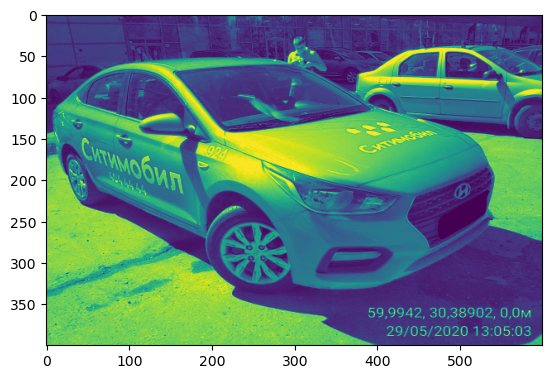

In [69]:
img, dmg = damage_dataset[4010]
plt.imshow(img[0]);
print(class_names[dmg.item()])

In [71]:
print(class_names[torch.argmax(model_pl1(img.unsqueeze(0))).item()])

Поврежден
